# Validation of external NTCP models

## Data loading

In [19]:
import pandas as pd
import numpy as np

# Load general patient info
patient_info = pd.read_csv('data/final/patient_info.csv')
patient_info = patient_info[patient_info['has_baseline'] & patient_info['has_dose']]
patient_info.set_index('patient', drop=False, inplace=True)

def prepare_data(months, drop_null=[], to_remove={}, to_binarise={}, to_add=[], 
                 to_binarise_range={}, patients=None):
    """Load a DataFrame, drop unwanted entries, and add any extra columns.
    
    Arguments:
    months -- follow-up timepoint to load
    drop_null -- list of columns for which to drop null entries
    to_remove -- dict of columns with a list of values to remove
    to_binarise -- dict of columns to binarise
    to_add -- list of extra features to add from patient data
    to_binarise_range -- dict of columns to binarise, with a min and max value for each
    patients -- list of patients to load. If None, all will be loaded
    """
    
    # Read in data
    df = pd.read_csv(f'data/final/late_{months}_months.csv')
    
    # Remove patients not in patient list
    if patients is not None:
        df = df[df['patient'].isin(patients)]
            
    # Remove null entries
    for feature in drop_null:
        n_to_drop = df[feature].isnull().sum()
        if n_to_drop:
            print(f'[INFO] Dropping {n_to_drop} entries with null {feature}')
        df=df[df[feature].notnull()]
    
    # Remove patients if required
    for feature, values in to_remove.items():
        if not isinstance(values, list):
            values = [values]
        idx_to_remove = df[df[feature].isin(values)].index
        print(f'[INFO] Removing {len(idx_to_remove)} entries with {feature} in {values}')
        df.drop(idx_to_remove, inplace=True)
        
    # Create new columns
    for feature, name_dict in to_binarise.items():
        for name, value in name_dict.items():
            print(f'[INFO] Adding new column {name} ({feature} == {value})')
            if isinstance(value, list):
                df[name] = (df[feature].isin(value)).astype(int)
            else:
                df[name] = (df[feature] == value).astype(int)
                
    # Binarise ranges
    for feature, name_dict in to_binarise_range.items():
        for name, value in name_dict.items():
            print(f'[INFO] Adding new column {name} ({value[0]} < {feature} < {value[1]}])')
            df[name] = ((df[feature] > value[0]) & (df[feature] < value[1])).astype(int)
            
    # Add extra info from patient data
    for feature in to_add:
        print(f'[INFO] Adding column {feature} from patient info dataframe')
        df[feature] = df['patient'].apply(
            lambda p: patient_info.loc[p, feature])
    
    # Reset index and return dataframe
    df.reset_index(drop=True)
    print(f'[INFO] Loaded dataset with {len(df)} entries')
    return df

### Make demographics table of data

In [20]:
import json
from scipy.stats import chi2_contingency

def start_table(file, caption, fmt, headers, extra_rule=False, extra_header=''):
    """Print the start of a latex table to a file.
    
    Arguments:
    file -- a file object to write to.
    caption -- table caption.
    fmt -- format string for a latex tabular.
    headers -- list of column headers (must match fmt).
    extra_rule -- whether to add a second midrule after header.
    extra_line -- optional extra header line
    """
    
    file.write('\\begin{table}\n')
    file.write(f'    \\caption{{{caption}}}\n')
    file.write('    \\begin{tabular}{llrrl}\n')
    file.write('        \\toprule\n')
    header_line = '        '
    if len(extra_header):
        file.write(extra_header)
    for i, h in enumerate(headers):
        header_line += h + ' '
        if i < len(headers) - 1:
            header_line += '& '
    header_line += '\\\\\n'
    file.write(header_line)
    file.write('        \\midrule\n')
    if extra_rule:
        file.write('        \\midrule\n')
        
     
def end_table(file, label):
    """Write the end of a latex table to file, with label"""
    
    file.write('        \\bottomrule\n')
    file.write('    \\end{tabular}\n')
    file.write('\\end{table}\n')
    file.write(f'\\label{{tab:{label}}}\n')
        

def demographics_table(name, df, to_compare=None):
    """Create a .tex file containing a table comparing a DataFrame to an existing demographic.
    
    Arguments:
    name -- name of .tex file. If no comparison dict is provided, this name is used to 
            load an existing .json file.
    df -- the DataFrame to compare to a dict.
    to_compare -- dict of characteristics and population counts. Not needed if a json file exists.
    """
    
    # Load json if required
    name2 = name.replace(' ', '_').lower()
    if to_compare is None:
        with open(f'demographics/{name2}.json') as file:
            to_compare = json.load(file)
    
    # Open latex file and set up table
    file = open(f'demographics/{name2}.tex', 'w')
    caption = f'Demographics and tumour characteristics for the {name} cohort' \
              f' (training set) and the VoxTox cohort (validation set).'
    fmt = 'llrrr'
    headers = ['Characteristic', 'Value', name, 'VoxTox', '$p$-value']
    start_table(file, caption, fmt, headers, extra_rule=True)
    
    # Write number of patients first if included
    if 'n_patients' in to_compare:
        file.write(f'        \\multicolumn{{2}}{{l}}{{Number of patients}} & {to_compare["n_patients"]}'
                   f' & {len(df)} & \\\\\n')
        file.write('        \\midrule\n')
    
    # Loop through characteristics
    for c in to_compare.keys():
        if c == 'n_patients':
            continue
        file.write(f'        {c.capitalize()} &')
        cats = to_compare[c]
        
        # Make arrays for chisq test
        vals1 = []
        vals2 = []
        
        # Loop through categories of the characteristic
        extra_lines = []
        counted = 0
        n_other = 0
        use_p_val = True
        for i, cat in enumerate(cats.keys()):
            val1 = cats[cat]
            name = cat.capitalize()
            
            # Extract characteristic from VoxTox dataset
            val2 = 0
            
            # Sex
            if c == 'sex':
                val2 = (df['male'] == (cat == 'male')).sum()
                
            # Age
            elif c == 'age':
                if cat.startswith('<'):
                    cutoff = int(cat[2:])
                    val2 = (df['age'] < cutoff).sum()
                    name = f'$< {cutoff}$'
                elif cat.startswith('>'):
                    cutoff = int(cat[2:])
                    val2 = (df['age'] >= cutoff).sum()
                    name = f'$>= {cutoff}$'
                elif cat == 'mean':
                    use_p_val = False
                    val2 = f'{df["age"].mean():.1f}'
                elif cat == 'range':
                    use_p_val = False
                    val2 = f'{int(df["age"].min())} -- {int(df["age"].max())}'
            
            # Cisplatin/cetuximab
            elif c == 'chemotherapy':
                var_to_use = 'cisplatin' if 'cetuximab' in to_compare else 'SACT'
                val2 = (df[var_to_use] == (cat == 'yes')).sum()
            elif c == 'cetuximab':
                val2 = ((df['SACT'] & ~df['cisplatin']) == (cat == 'yes')).sum()
                
            # Tumour site
            elif c == 'site':
                site = cat
                if cat == 'unknown primary':
                    site = 'CUP'
                if cat == 'other':
                    n_other = val1
                    continue
                val2 = (df['primary site'] == site).sum()
                counted += val2
                
            # Tumour classification
            elif c == 'tumour classification':
                T_stage = int(cat[-1])
                val2 = (df['T_stage'] == T_stage).sum()
            elif c == 'node classification':
                val2 = ((df['N_stage'] > 0) == (cat == 'positive')).sum()
                
            # Neck irradiation
            elif c == 'bilateral neck irradiation':
                val2 = (df['neck_bi'] == (cat == 'yes')).sum()
                
            # Unknown characteristic
            else:
                print(f'[INFO] Characteristic {c} not recognised!')
                
            # Add values to arrays
            vals1.append(val1)
            vals2.append(val2)
                
            # Write info to file
            if i == 0:
                file.write(f' {name} & {val1} & {val2} & ')
            else:
                extra_lines.append(f'        & {name} & {val1} & {val2} & \\\\\n')
                
        # Extra line for patients with other tumour sites
        if c == 'site' and (counted != len(df) or n_other):
            diff = len(df) - counted
            extra_lines.append(f'        & Other & {n_other} & {diff} & \\\\\n')
            vals1.append(n_other)
            vals2.append(diff)
            site_list = list(cats.keys()) + ['CUP']
            sites_missed = df[~df['primary site'].isin(site_list)]['primary site'].unique()
            print('[INFO] The following tumour sites were classified as "other":')
            print('      ', sites_missed)
                
        # Calculate p-value
        obs = np.array([vals1, vals2])
        p_to_write = ''
        if use_p_val:
            chi2, p_val, dof, exp = chi2_contingency(obs)
            p_to_write = '$< 0.01$' if p_val < 0.01 else f'{p_val:.2f}'
        file.write(f'{p_to_write} \\\\\n')
        
        # Write extra lines
        for line in extra_lines:
            file.write(line)
            
        # Write midrule if needed
        if c != list(to_compare.keys())[-1]:
            file.write('        \\midrule\n')
            
    # End table
    end_table(file, f'{name2}_demog')
    file.close()
    

## Model validation

In [21]:
# Class for performing model validation
import os
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.metrics import plot_roc_curve
from scipy.stats import chi2
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


class ModelValidator():
    
    def __init__(self, name, model, X, y, retrain=True, use_bootstrap=False):
        """Write performance metrics and produce plots for a given model. 
        The model is also retrained on X and y.

        Arguments:
        name -- this determines the location of output logs/plots.
        model -- a model with coefficients set.
        X -- input features.
        y -- true outcomes.
        use_bootstrap -- if True, the ROC AUC confidence interval is calculated with bootstrapping.

        Return values:
        model_retrained -- original model retrained on X and y.
        """
    
        # Initial settings
        self.name = name
        self.models = {'original': model}
        self.X = X
        self.y = y
        self.use_bootstrap = use_bootstrap
        self.set_outdirs()
        self.metrics = {}
        self.y_pred = {}
        self.y_prob = {}
    
        # Open performance log file
        self.file = open(f'{self.outdir}/validation.log', 'w')

        # Print prevalence
        self.file.write(f'Number of patients: {len(X)}\n')
        self.prev = self.y.sum() / self.y.count()
        self.file.write(f'Prevalence: {self.prev * 100:.1f}%\n\n')

        # Get retrained model
        if retrain:
            self.models['retrained'] = self.retrain_model(model)

        # Get performance of both models
        for m in self.models.keys():
            
            # Get performance metrics
            self.get_performance_metrics(m)

            # Print metrics to log file
            self.print_model_performance(m)

            # Plot probability distributions
            if self.y.nunique() > 1:
                self.plot_probabilities(m)

        # Plot ROC on same axis
        if self.y.nunique() > 1:
            self.plot_roc()

        # Close file
        self.file.close()
        print(f'\n[INFO] Model validation log saved to {self.outdir}/validation.log')

    def set_outdirs(self):
        """Ensure that validation results and figure directories exist for a 
        given name, and return the paths to these directories."""
        self.outdir = 'validation_results/' + self.name.replace(' ', '_')
        if not os.path.isdir(self.outdir):
            os.mkdir(self.outdir)
        self.figdir = self.outdir + '/figs'
        if not os.path.isdir(self.figdir):
            os.mkdir(self.figdir)
            
    def plot_features(self, feature_titles=None):
        """Plot histograms of each feature
        Can optionally pass a dict of titles for each feature."""
        if feature_titles == None:
            feature_titles = {f: f for f in X.columns}
        for f, title in feature_titles.items():
            plt.figure();
            self.X[f].hist();
            plt.xlabel(title)
            plt.ylabel('Number of entries')
            plt.savefig(os.path.join(self.figdir, f'distribution_{f}.pdf'))
            plt.close()
            
    def retrain_model(self, model):
        """Return a new version of a given model, retrained on X and y."""
        if isinstance(model, LogisticRegression):
            model_retrained = LogisticRegression()
            print('[INFO]: Retraining logistic regression model')
            model_retrained.fit(self.X, self.y)
            return model_retrained
        
    def get_performance_metrics(self, m):
        """Fill dictionaries with performance metrics for a given model.
        
        Arguments:
        m -- model name
        """
        
        # Check the model exists
        if m not in self.models:
            print(f'[ERROR]: model {m} does not exist.')
            return
        
        # Make container for the metrics
        self.metrics[m] = {}
        
        # Get predicted outcomes and probabilties
        self.y_pred[m] = self.models[m].predict(self.X)
        self.y_prob[m] = self.models[m].predict_proba(self.X)[:, 1]
        
        # Find Brier score
        self.metrics[m]['brier_score'] = brier_score_loss(self.y, self.y_prob[m])
        self.metrics[m]['brier_score_custom'] = np.sum((self.y_prob[m] - self.y)**2) / len(self.y)
        self.brier_max = self.prev * (1 - self.prev)
        self.metrics[m]['brier_score_scaled'] = self.metrics[m]['brier_score'] / self.brier_max
        
        # Find ROC AUC
        if self.y.nunique() > 1:
            auc = roc_auc_score(self.y, self.y_prob[m])
            self.metrics[m]['auc'] = auc
        
            # Estimate ROC confidence interval assuming Gaussian distribution
            N1 = self.y.sum()
            N2 = len(self.y) - N1
            Q1 = auc / (2 - auc)
            Q2 = 2 * auc**2 / (1 + auc)
            SE = np.sqrt(
                (auc * (1 - auc) + (N1 - 2) * (Q1 - auc**2) + (N2 - 1) * (Q2 - auc**2))
                / (N1 * N2)
            )
            z = 1.96
            self.metrics[m]['auc_lower'] = auc - z * SE
            self.metrics[m]['auc_upper'] = auc + z * SE

            # Estimate ROC confidence interval with bootstrapping
            if self.use_bootstrap:
                self.get_auc_bootstrap(m)
            
        # Get calibration metrics and plot calibration curve
        self.get_calibration(m)
        
        # Perform Hosmer-Lemeshow goodness-of-fit test
        # self.hosmer_lemeshow(m)
            
    def get_auc_bootstrap(self, m):
        """Estimate AUC distribition using bootstrapping for a given model.
        
        Arguments:
        m --  model name
        """

        # Get distribution
        n_iter = 1000
        X_and_y = self.X.copy()
        X_and_y['y'] = self.y
        auc_scores = []
        for i in range(n_iter):
            to_use = resample(X_and_y, n_samples=len(X_and_y))
            X_to_use = to_use.drop('y', axis=1)
            y_to_use = to_use['y']
            y_prob_bootstrap = self.models[m].predict_proba(X_to_use)[:, 1]
            auc_scores.append(roc_auc_score(y_to_use, y_prob_bootstrap))
        self.metrics[m]['auc_bootstrap'] = np.mean(auc_scores)

        # Calculate confidence interval
        alpha = 0.95
        p = ((1.0 - alpha) / 2.0) * 100
        self.metrics[m]['auc_bootstrap_lower'] = max(
            0.0, np.percentile(auc_scores, p))
        p = (alpha + ((1.0 - alpha) / 2.0)) * 100
        self.metrics[m]['auc_bootstrap_upper'] = min(
            1.0, np.percentile(auc_scores, p))

        # Plot distribution
        plt.figure();
        plt.xlabel('ROC AUC')
        plt.ylabel('Number of bootstrap samples')
        ax = plt.gca()
        y_hist, x_hist, _ = ax.hist(auc_scores, label='Bootstrap')

        # Add Gaussian from simple calculation
        x_plt = np.arange(ax.get_xlim()[0], ax.get_xlim()[1], 0.01)
        y_plt = np.exp(-(x_plt - auc)**2 / (2 * SE**2)) * y_hist.max()
        plt.plot(x_plt, y_plt, 'r', label='Gaussian');
        plt.legend()
        plt.savefig(os.path.join(self.figdir, 'ROC_AUC_bootstrap.pdf'), dpi=150)
        plt.close()
          
    def get_calibration(self, m, bins=8):
        """Plot the calibration curve for a model and print slope/intercept to a file.

        Arguments:
        m -- model name.
        bins -- number of bins.
        """
        fraction_of_positives, mean_predicted_value = calibration_curve(
            self.y, self.y_prob[m], n_bins=bins)
        plt.figure();
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated");
        plt.scatter(mean_predicted_value, fraction_of_positives, label=self.name);
        plt.xlabel('Predicted risk')
        plt.ylabel('Observed risk')

        # Get calibration slope and intercept
        p = np.polyfit(mean_predicted_value, fraction_of_positives, 1)
        self.metrics[m]['calibration_slope'] = p[0]
        self.metrics[m]['calibration_intercept'] = p[1]

        # Plot line of best fit and save
        x_plt = np.arange(0, 1, 0.01);
        plt.plot(x_plt, p[0] * x_plt + p[1], label='Line of best fit');
        plt.legend();
        plt.savefig(os.path.join(self.figdir, f'calibration_{m}.pdf'))
        plt.close()

    def print_model_performance(self, m):
        """Print performance metrics for a given model to the log file.

        Arguments:
        m -- model name
        """

        # Print model coefficients 
        if isinstance(self.models[m], LogisticRegression):
            self.file.write(f'\nPARAMETERS OF {m.upper()} MODEL:\n')
            for i, coef in enumerate(self.models[m].coef_[0]):
                self.file.write(f'Coef. of {self.X.columns[i]}: {coef}\n')
            self.file.write(f'Intercept: {self.models[m].intercept_[0]}\n\n')

        # Classification report/confusion matrix
        self.file.write('CLASSIFICATION REPORT:\n')
        self.file.write(classification_report(self.y, self.y_pred[m]))
        self.file.write('\nCONFUSION MATRIX:\n')
        self.file.write(pd.crosstab(
            self.y, self.y_pred[m], rownames=['True'], colnames=['Predicted'], 
            margins=True).to_string())

        # Brier score
        self.file.write('\n\nBRIER SCORE:\n')
        self.file.write(f'Brier score: '
                        f'{self.metrics[m]["brier_score"]:.3f}\n')
        self.file.write(f'Brier score (manual): '
                        f'{self.metrics[m]["brier_score_custom"]:.3f}\n')
        self.file.write(f'Max Brier score: '
                        f'{self.brier_max:.3f}\n')
        self.file.write(f'Scaled Brier score: '
                        f'{self.metrics[m]["brier_score_scaled"]:.3f}\n')

        # Mean probabilities for both cases
        self.file.write(f'Mean probability for entries with toxicity: '
                        f'{self.y_prob[m][self.y == 1].mean():.3f}\n')
        self.file.write(f'Mean probability for entries without toxicity: '
                        f'{self.y_prob[m][self.y == 0].mean():.3f}\n')

        # Calculate ROC AUC
        if "auc" in self.metrics[m]:
            self.file.write('\nROC AREA UNDER CURVE:\n')
            self.file.write(f'Area under ROC: {self.metrics[m]["auc"]:.3f}\n')
            self.file.write(f'95% confidence interval: '
                       f'[{self.metrics[m]["auc_lower"]:.3f}, '
                       f'{self.metrics[m]["auc_upper"]:.3f}]\n')

        # Write details from bootstrapping
        if self.use_bootstrap:
            self.file.write('\nROC AREA UNDER CURVE (BOOTSTRAPPING):\n')
            self.file.write(f'Mean area under curve: '
                            f'{self.metrics[m]["auc_bootstrap"]:.3f}\n')
            self.file.write(f'{alpha * 100}% confidence interval: '
                            f'[{self.metrics[m]["auc_bootstrap_lower"]:.3f}, '
                            f'{self.metrics[m]["auc_bootstrap_upper"]:.3f}]\n')

        # Write calibration metrics
        self.file.write('\nCALIBRATION:\n')
        self.file.write(f'Slope: {self.metrics[m]["calibration_slope"]:.3f}\n')
        self.file.write(f'Intercept: {self.metrics[m]["calibration_intercept"]:.3f}\n')
        
        # Write Hosmer-Lemeshow test results
#         self.file.write('\nHOSMER-LEMESHOW GOODNESS-OF-FIT TEST:\n')
#         self.file.write(f'HL chi^2: {self.metrics[m]["hl_chi2"]:.3f}\n')
#         self.file.write(f'p-value: {self.metrics[m]["hl_pval"]:.3f}\n')

    def plot_probabilities(self, m):
        """Plot the distributions of predicted probabilities for cases with and without true toxicity.

        Arguments:
        m -- model name.
        """

        plt.figure()
        for tox in [0, 1]:
            y_prob_sub = self.models[m].predict_proba(self.X[self.y == tox])[:, 1]
            plt.hist(y_prob_sub, label=f'Toxicity = {tox}', alpha=0.3, linestyle='solid')
        plt.legend()
        plt.xlabel('Predicted probability')
        plt.ylabel('Number of entries')
        plt.savefig(os.path.join(self.figdir, f'probabilities_{m}.pdf'))
        plt.close()

    def plot_roc(self):
        """Plot ROC curve for all models and save to a file."""

        fig = plt.figure()
        ax = plt.gca()
        for m, model in self.models.items():
            plot_roc_curve(model, self.X, self.y, 
                           label=m, ax=ax)
        ax.plot([0, 1], [0, 1], "k:", label="Chance")
        ax.legend(loc='lower right')
        fig.savefig(os.path.join(self.figdir, 'ROC.pdf'))
        plt.close()
        
    def hosmer_lemeshow(self, m, g=10):
        """Perform a Hosmer-Lemeshow goodness-of-fit test.
        
        Arguments:
        m -- Model name.
        g -- Number of groups to use for the test."""
        
        bin_width = (np.max(self.y_prob[m]) - np.min(self.y_prob[m])) / g
        bins_low = np.arange(np.min(self.y_prob[m]), np.max(self.y_prob[m]), bin_width)
        ones = np.zeros(g)
        zeros = np.zeros(g)
        hl_stat = 0
        for i in range(g):

            # Get number of true ones and zeros in this group
            for j, p in enumerate(self.y_prob[m]):
                if p > bins_low[i] and p < bins_low[i] + bin_width:
                    true_y = self.y.iloc[j]
                    if true_y:
                        ones[i] += 1
                    else:
                        zeros[i] += 1

            # Add to the score
            exp_ones = (bins_low[i] + bin_width / 2) * (ones[i] + zeros[i])
            exp_zeros = ones[i] + zeros[i] - exp_ones
            hl_stat += (zeros[i] - exp_zeros)**2 / exp_zeros + (ones[i] - exp_ones)**2 / exp_ones

        # Calculate p-value from HL score
        dof = g - 2
        pval = chi2.cdf(hl_stat, dof)
        self.metrics[m]['hl_chi2'] = hl_stat
        self.metrics[m]['hl_pval'] = pval
        

In [22]:
# Class for validating a logistic regression
from sklearn.linear_model import LogisticRegression

class LogisticRegressionValidator(ModelValidator):
    
    def __init__(self, name, df, coefs, intercept, 
                 outcome, retrain=True, use_bootstrap=False, 
                 feature_titles=None):
        """Create and validate a logistic regression model
        
        Arguments:
        name -- Name of the model. Affects the location of output files.
        df -- Pandas DataFrame whose columns include the features and outcome.
        coefs -- Dict containing strings corresponding to feature names in df 
                 and a numerical coefficient for each.
        intercept -- Intercept of the model.
        outcome -- String corresponding to the column of the outcome in df
        use_bootstrap -- Whether to use bootstrapping to calculate ROC AUC 
                         confidence interval.
        feature_titles -- Dict of titles to optionally use for each feature in plots.
        """
        
        # Make X and y
        self.features = list(coefs.keys())
        self.coefs = coefs
        self.intercept = intercept
        self.df = df
        X = df[self.features]
        y = df[outcome]
        
        # Create model
        model = LogisticRegression()
        
        # Initial fit (doesn't matter, but needed to initialise model)
        X_for_fit = X
        y_for_fit = y
        if y.nunique() == 1:
            # For fitting, must have 2 different classes in y; create dummy entry
            dummy_row = X.iloc[0]
            X_for_fit = X.append(dummy_row, ignore_index=True)
            y_for_fit = y.append(pd.Series([1 - y.iloc[0]], index=[len(y)]))
        model.fit(X_for_fit, y_for_fit)
        
        # Set model coefficients
        model.coef_ = np.array([list(coefs.values())])
        model.intercept_ = np.array([intercept])
        
        # Initialise parent class (this runs the validation)
        ModelValidator.__init__(self, name, model, X, y, retrain=retrain, 
                                use_bootstrap=use_bootstrap)
        
        # Plot distributions of features
        if feature_titles == None:
            feature_titles = {f: f for f in self.features}
        self.feature_titles = {self.features[i]: feature_titles[self.features[i]] if i < len(feature_titles) 
                               else self.features[i] for i in range(len(self.features))}
        self.plot_features(self.feature_titles)
        
    # Perform univariate analysis
    def univariate_analysis(self, v):
        """Perform univariate logistic regressions for variables in var_list and 
        write the output to a latex file. var_list can also be a dictionary
        providing titles to give each variable in the table."""
        
        # Get list of variables and dict of titles
        var_titles = {}
        var_list = []
        if isinstance(v, list):
            var_titles = {v: v for v in v}
            var_list = v
        elif isinstance(v, dict):
            var_titles = v
            var_list = list(v.keys())
            
        # Create latex table
        file = open(f'{self.outdir}/univariate.tex', 'w')
        extra_header = '        & \\multicolumn{2}{c}{Beetz 2012} & \\multicolumn{2}{c}{VoxTox} \\\\\n'
        start_table(file, f'Univariate analysis of {self.name.capitalize().replace("_", " ")}', 
                    'ccccc', ['Variable', '$\\beta$', 'Odds ratio', '$\\beta$', 'Odds ratio'], 
                    extra_header=extra_header)
        
        # Load univariate coefficients from original paper
        orig_coefs = {}
        with open(f'data/univariate_analysis/{self.name}.json') as uni_file:
            orig_coefs = json.load(uni_file)
            
        # Run logistic regression for each
        coefs = {}
        odds_ratios = {}
        for v in var_list:
            coef, odds_ratio = self.univariate_single(v)
            orig_coef = orig_coefs[v]
            orig_odds_ratio = np.exp(orig_coef)
            file.write(f'        {var_titles[v]} & {orig_coef:.2f} & '
                       f'{orig_odds_ratio:.2f} & {coef:.2f} & {odds_ratio:.2f} \\\\\n')
            
        # End the table
        end_table(file, f'{self.name}_uni')
        
    # Univariate analysis of single variable
    def univariate_single(self, v):
        """Perform univariate logistic regression for one variable"""
        
        model = LogisticRegression()
        X_to_use = self.df[[v]][self.df[v].notnull()]
        y_to_use = self.y[X_to_use.index]
        model.fit(X_to_use, y_to_use)
        coef = model.coef_[0][0]
        odds_ratio = np.exp(coef)
        return coef, odds_ratio
        
    # Plot logistic regression model
    def plot_log_reg(self, hue_var, hue_vals=None, hue_data=False, nbins=6, same_axis=True):
        """Plot logistic regression curve(s) for original and retrained models.
        
        Arguments:
        hue_var -- Feature for which to plot curves in a different hue.
        hue_vals -- Values of this feature for which to plot 
                    (default = all different values)
        hue_data -- Option to also plot real data points in different colours
                    (default = all in same colour)
        nbins -- Number of bins to use for binning data.
        same_axis -- Option to plot the original and retrained model on the same axis.
        """
        
        # Create figure
        n_subplots = 1 if same_axis else 2
        fig, ax = plt.subplots(1, n_subplots, figsize=(8 * n_subplots, 6))
        
        # Plot both models
        ax1 = ax if same_axis else ax[0]
        ax2 = ax if same_axis else ax[1]
        title1 = self.name.capitalize().replace('_', ' ') + ' model' if same_axis else 'Original model'
        title2 = title1 if same_axis else 'Retrained model'
        self.plot_single_log_reg('original', ax1, hue_var, hue_vals, 
                                 hue_data, nbins, legend=(not same_axis),
                                 name_in_legend=same_axis, title=title1)
        self.plot_single_log_reg('retrained', ax2, hue_var, hue_vals, 
                                 hue_data, nbins, plot_data=(not same_axis),
                                 dotted=same_axis, name_in_legend=same_axis,
                                 data_in_legend=False, title=title2)
        if same_axis:
            ax.legend()
        fig.savefig(os.path.join(self.figdir, 'NTCP_model.pdf'))
        plt.close()
        print('\n[INFO] Plotted logistic regression model')
        
    def plot_single_log_reg(self, m, ax, hue_var, hue_vals=None, 
                            hue_data=False, nbins=6, legend=False,
                            plot_data=True, dotted=False, name_in_legend=False,
                            data_in_legend=True, title=''):
        """Plot a single logistic regression model on a given axis.
        
        Arguments:
        m -- Name of model (original/retrained).
        ax -- Matplotlib axis on which to plot.
        plot_data -- Whether or not to plot real data points.
        dotted -- Whether to use dotted lines.
        name_in_legend = Whether to include model name in legend labels.
        data_in_legend = Whether to include data points in legend.
        title -- Optional figure title.
        """
        
        # Get coefficients and intercept of the model
        model = self.models[m]
        coefs = {self.features[i]: model.coef_[0][i] for i in range(len(self.features))}
        intercept = model.intercept_[0]
        if isinstance(hue_var, str):
            hue_var = [hue_var]

        # Make variable for x axis
        features = [f for f in self.features if f not in hue_var]
        x = self.X[features[0]] * 0
        x_name = ''
        if len(features) == 1:
            x = self.X[features[0]]
            x_name = self.feature_titles[features[0]]
        else:
            for f in features:
                x += coefs[f] * self.X[f]
                plus = ' +' if len(x_name) else ''
                x_name += f'{plus}{coefs[f]:.2f} x {self.feature_titles[f]}'

        # Define the model
        def log_reg(x, h):
            """Return output of logistic regression function for a 
            given dictionary of variables/values (h) and a linear combination
            of all other features (x)."""
            S = intercept
            for var, val in h.items():
                S += coefs[var] * val
            if len(features) == 1:
                S += coefs[features[0]] * x
            else:
                S += x
            return 1 / (1 + np.exp(-S))

        # Plot NTCP curves for each hue value
        x_plt = np.arange(x.min(), x.max(), 0.1)
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
        linestyle = ':' if dotted else '-'
        
        # Case with one variable, multiple values
        if len(hue_var) == 1:
            
            # If no hue values are given, use all unique values
            if hue_vals is None:
                if len(hue_var) == 1:
                    hue_vals = self.X[hue_var[0]].unique() 
                    
            # Plot each
            for i, h in enumerate(hue_vals):
                label = f'{self.feature_titles[hue_var[0]]} = {h}'
                if name_in_legend:
                    label += f' ({m})'
                ax.plot(x_plt, 
                        log_reg(x_plt, {hue_var[0]: h}), 
                        color=colors[i], 
                        linestyle=linestyle, 
                        label=label);
        
        # Case with multiple binary variables
        else:
            for i, hv in enumerate(hue_var):
                label = self.feature_titles[hv]
                h_vals = {h: (h == hv) for h in hue_var}
                y_plt = log_reg(x_plt, h_vals)
                ax.plot(x_plt, y_plt,
                       color=colors[i],
                       linestyle=linestyle,
                       label=label)
        
        # Set x/y labels
        ax.set_xlabel(x_name)
        ax.set_ylabel('NTCP')

        # Bin the data
        bin_width = (x.max() - x.min()) / (nbins)
        bin_centres = np.arange(x.min(), x.max(), bin_width) + bin_width / 2

        # Get prevalence in each bin
        hue_data = hue_data and len(hue_var) == 1  # Only allow data hues with single variable for now
        X_subsets = {h: self.X[self.X[hue_var[0]] == h] for h in hue_vals} if hue_data \
            else {'all': self.X}
        prevs = {}
        prev_errs = {}
        for i, (h, X_sub) in enumerate(X_subsets.items()):
            prevs[h] = []
            prev_errs[h] = []
            for b in bin_centres:
                prev, sigma = self.get_prev_in_bin(x[X_sub.index], b, bin_width)
                prevs[h].append(prev)
                prev_errs[h].append(sigma)
            label = 'True prevalence' if h == 'all' else f'{self.feature_titles[hue_var[0]]} = {h}'
            color = 'k' if h == 'all' else colors[i]
            if data_in_legend:
                ax.errorbar(bin_centres, prevs[h], yerr=prev_errs[h], 
                             fmt='o', color=color, label=label)
            else:
                ax.errorbar(bin_centres, prevs[h], yerr=prev_errs[h], 
                             fmt='o', color=color)

        # Set title and legend
        if legend:
            ax.legend()
        ax.set_title(title)
     
    def get_prev_in_bin(self, x, bin_centre, bin_width):
        """Get mean prevalence in a bin"""
        x_in_bin = x[abs(x - bin_centre) <= bin_width / 2]
        n = len(x_in_bin)
        n_tox = self.y[x_in_bin.index].sum()
        prev = n_tox / n
        sigma = np.sqrt(prev * (1 - prev)/ n)
        return prev, sigma
        
        

## Beetz 2012 xerostomia
https://www.thegreenjournal.com/article/S0167-8140(12)00117-X/fulltext

In [23]:
# Load data
df = prepare_data(
    months=6, 
    drop_null=['parotid_contralateral_planned', 'baseline_EORTC_dry_mouth'],
    to_remove={'baseline_EORTC_dry_mouth': [3, 4]},
    to_binarise={'baseline_EORTC_dry_mouth': {'baseline_EORTC_dry_mouth_binary': 2}}
)
df['cetuximab'] = (df['SACT'] & ~df['cisplatin'])
demographics_table('Beetz 2012', df)

# Validate model
coefs = {
    'parotid_contralateral_planned': 0.047,
    'baseline_EORTC_dry_mouth_binary': 0.720
}
feature_titles = {
        'parotid_contralateral_planned': 'Contralateral parotid mean dose (Gy)',
        'baseline_EORTC_dry_mouth_binary': 'Baseline xerostomia'
}
intercept = -1.443
lrv = LogisticRegressionValidator('beetz_2012', df, coefs, intercept, 'EORTC_dry_mouth',
                                  feature_titles=feature_titles)

# Plot the model
lrv.plot_log_reg(hue_var='baseline_EORTC_dry_mouth_binary', hue_data=True, same_axis=True)

# Run univariate analysis
uni = {
    'parotid_contralateral_planned': 'Contralateral parotid mean dose (Gy)',
    'parotid_ipsilateral_planned': 'Ipsilateral parotid mean dose (Gy)',
    'smg_contralateral_planned': 'Contralateral submandibular mean dose (Gy)',
    'smg_ipsilateral_planned': 'Ipsilateral submandibular mean dose (Gy)',
    'male': 'Sex',
    'age': 'Age',
    'cisplatin': 'Chemotherapy',
    'cetuximab': 'Cetuximab',
    'baseline_EORTC_dry_mouth_binary': 'Baseline xerostomia (none vs. a bit)',
    'neck_bi': 'Bilateral neck irradiation'
}
lrv.univariate_analysis(uni)


[INFO] Dropping 6 entries with null baseline_EORTC_dry_mouth
[INFO] Removing 19 entries with baseline_EORTC_dry_mouth in [3, 4]
[INFO] Adding new column baseline_EORTC_dry_mouth_binary (baseline_EORTC_dry_mouth == 2)
[INFO] Loaded dataset with 157 entries
[INFO] The following tumour sites were classified as "other":
       ['skin' 'salivary gland' 'maxilla' nan 'SCC' 'carotid body' 'parotid']
[INFO]: Retraining logistic regression model

[INFO] Model validation log saved to validation_results/beetz_2012/validation.log

[INFO] Plotted logistic regression model


## External validation of original Beetz 2012 data

In [24]:
# Load data
df = pd.read_csv("../Beetz cross validation/Beetz_2012.csv")
df["xerostomia_baseline_binary"] = df["Xerostomia_baseline"] - 1

# Validate model
coefs = {
    'PC_Dmean': 0.047,
    'xerostomia_baseline_binary': 0.720
}
feature_titles = {
        'PC_Dmean': 'Contralateral parotid mean dose (Gy)',
        'xerostomia_baseline_binary': 'Baseline xerostomia'
}
intercept = -1.443
lrv = LogisticRegressionValidator('beetz_2012_original', df, coefs, intercept, 'RESP_XER_M06',
                                  feature_titles=feature_titles)

# Plot the model
lrv.plot_log_reg(hue_var='xerostomia_baseline_binary', hue_data=True, same_axis=True)

[INFO]: Retraining logistic regression model

[INFO] Model validation log saved to validation_results/beetz_2012_original/validation.log

[INFO] Plotted logistic regression model


## Lee 2014 xerostomia - all HNC
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0089700
### 3-month model

In [11]:
# Load data
df = prepare_data(
    months=3, 
    drop_null=['parotid_contralateral_planned', 'parotid_ipsilateral_planned', 
               'baseline_EORTC_dry_mouth', 'age'],
    to_remove={'baseline_EORTC_dry_mouth': [3, 4]}
)

# Validate model
coefs = {
    'parotid_contralateral_planned': 0.097,
    'parotid_ipsilateral_planned': 0.101,
    'age': 0.285}
intercept = -21.298
feature_titles = {
        'parotid_contralateral_planned': 'Contralateral parotid mean dose (Gy)',
        'parotid_ipsilateral_planned': 'Ipsilateral parotid mean dose (Gy)',
        'age': 'Age'
}
lrv = LogisticRegressionValidator(
    'lee_2014_3month_combined', df, coefs, intercept, 'EORTC_dry_mouth',
    feature_titles=feature_titles)

# Plot the model
lrv.plot_log_reg(
    hue_var='age', hue_vals=[40, 50, 60, 70], hue_data=False, same_axis=False)




[INFO] Dropping 12 entries with null parotid_ipsilateral_planned
[INFO] Dropping 5 entries with null baseline_EORTC_dry_mouth
[INFO] Removing 15 entries with baseline_EORTC_dry_mouth in [3, 4]
[INFO] Loaded dataset with 156 entries
[INFO]: Retraining logistic regression model

[INFO] Model validation log saved to validation_results/lee_2014_3month_combined/validation.log

[INFO] Plotted logistic regression model


## Lee 2014 xerostomia
https://www.nature.com/articles/srep06217
### 3-month model

In [228]:
# Load data
df = prepare_data(
    months=3, 
    drop_null=['parotid_contralateral_planned', 'parotid_ipsilateral_planned', 
               'baseline_EORTC_dry_mouth', 'age'],
    to_remove={'baseline_EORTC_dry_mouth': [3, 4]}
)
demographics_table('Lee 2014', df)

# Validate model
coefs = {
    'parotid_contralateral_planned': 0.637,
    'parotid_ipsilateral_planned': 0.185,
    'age': 0.202}
intercept = -32.296
feature_titles = {
        'parotid_contralateral_planned': 'Contralateral parotid mean dose (Gy)',
        'parotid_ipsilateral_planned': 'Ipsilateral parotid mean dose (Gy)',
        'age': 'Age'
}
lrv = LogisticRegressionValidator(
    'lee_2014_3month', df, coefs, intercept, 'EORTC_dry_mouth',
    feature_titles=feature_titles)

# Plot the model
lrv.plot_log_reg(
    hue_var='age', hue_vals=[40, 50, 60, 70], hue_data=False, same_axis=False)




[INFO] Dropping 12 entries with null parotid_ipsilateral_planned
[INFO] Dropping 5 entries with null baseline_EORTC_dry_mouth
[INFO] Removing 15 entries with baseline_EORTC_dry_mouth in [3, 4]
[INFO] Loaded dataset with 156 entries
[INFO] The following tumour sites were classified as "other":
       ['maxilla' 'skin' 'nasopharynx' 'carotid body' 'salivary gland' nan 'SCC'
 'parotid']
[INFO]: Retraining logistic regression model

[INFO] Model validation log saved to validation_results/lee_2014_3month/validation.log

[INFO] Plotted logistic regression model


### 3-month model, surgery only, no NPC

In [238]:
# Load data
df = prepare_data(
    months=3, 
    drop_null=['parotid_contralateral_planned', 'parotid_ipsilateral_planned', 
               'baseline_EORTC_dry_mouth', 'age'],
    to_remove={'baseline_EORTC_dry_mouth': [3, 4], 
               'primary site': ['nasopharynx'], 
               'primary_surgery': [0]}
)

# Validate model
coefs = {
    'parotid_contralateral_planned': 0.637,
    'parotid_ipsilateral_planned': 0.185,
    'age': 0.202}
intercept = -32.296
feature_titles = {
        'parotid_contralateral_planned': 'Contralateral parotid mean dose (Gy)',
        'parotid_ipsilateral_planned': 'Ipsilateral parotid mean dose (Gy)',
        'age': 'Age'
}
lrv = LogisticRegressionValidator(
    'lee_2014_3month_surgery', df, coefs, intercept, 'EORTC_dry_mouth',
    feature_titles=feature_titles)

# Plot the model
lrv.plot_log_reg(
    hue_var='age', hue_vals=[40, 50, 60, 70], hue_data=False, same_axis=False)



[INFO] Dropping 12 entries with null parotid_ipsilateral_planned
[INFO] Dropping 5 entries with null baseline_EORTC_dry_mouth
[INFO] Removing 15 entries with baseline_EORTC_dry_mouth in [3, 4]
[INFO] Removing 5 entries with primary site in ['nasopharynx']
[INFO] Removing 64 entries with primary_surgery in [0]
[INFO] Loaded dataset with 87 entries
[INFO]: Retraining logistic regression model

[INFO] Model validation log saved to validation_results/lee_2014_3month_surgery/validation.log

[INFO] Plotted logistic regression model


### 12-month model

In [120]:
# Load data
df = prepare_data(
    months=12, 
    drop_null=['parotid_contralateral_planned', 'parotid_ipsilateral_planned', 'baseline_EORTC_dry_mouth', 'T_stage'],
    to_remove={'baseline_EORTC_dry_mouth': [3, 4], 'T_stage': 0},
    to_binarise={'T_stage': {f'T{i}': i for i in range(1, 5)}}
)

# Model parameters
coefs = {
    'parotid_contralateral_planned': 1.400,
    'parotid_ipsilateral_planned': 0.358,
    'T1': 0.622,
    'T2': -1.136,
    'T3': -19.544,
    'T4': 0
}
intercept = -44.877

# Perform validation
name = 'lee_2014_12month'
feature_titles = {
        'parotid_contralateral_planned': 'Contralateral parotid mean dose (Gy)',
        'parotid_ipsilateral_planned': 'Ipsilateral parotid mean dose (Gy)',
}
lrv = LogisticRegressionValidator(
    'lee_2014_12month', df, coefs, intercept, 'EORTC_dry_mouth',
    feature_titles=feature_titles)

# Plot model
lrv.plot_log_reg(
    hue_var=['T1', 'T2', 'T3', 'T4'],
    hue_data=False, same_axis=False)


[INFO] Dropping 12 entries with null parotid_ipsilateral_planned
[INFO] Dropping 9 entries with null baseline_EORTC_dry_mouth
[INFO] Removing 12 entries with baseline_EORTC_dry_mouth in [3, 4]
[INFO] Removing 15 entries with T_stage in [0]
[INFO] Adding new column T1 (T_stage == 1)
[INFO] Adding new column T2 (T_stage == 2)
[INFO] Adding new column T3 (T_stage == 3)
[INFO] Adding new column T4 (T_stage == 4)
[INFO] Loaded dataset with 134 entries
[INFO]: Retraining logistic regression model

[INFO] Model validation log saved to validation_results/lee_2014_12month/validation.log

[INFO] Plotted logistic regression model


### Wopken 2014 dysphagia
https://pubmed.ncbi.nlm.nih.gov/25443500/

In [24]:
# Load dose data from new contours
ipc_and_crico = pd.read_csv('../HeadAndNeck/doses.csv')

# Load other data
df = prepare_data(
    months=6, 
    patients=list(ipc_and_crico['patient']),
    drop_null=['parotid_contralateral_planned', 'T_high', 'SACT', 'cisplatin', 'weight_loss_pct'],
    to_remove={'baseline_CTCAE_dysphagia': [3, 4]},
    to_binarise_range={'weight_loss_pct': {'weight_loss_moderate': (1, 10), 
                                           'weight_loss_high': (10, 100000)}}
)

# Fill extra columns
df['cetuximab'] = (df['SACT'] & ~df['cisplatin'])
df['tube'] = (df['peg_tube'] | df['ng_tube'])
df['acc_RT'] = np.ones(len(df))
df = pd.merge(df, ipc_and_crico, on='patient')


# Validate model
coefs = {
    'T_high': 0.43,
    'weight_loss_moderate': 0.95,
    'weight_loss_high': 1.63, 
    'cetuximab': 0.56,
    'acc_RT': 1.20,
    'cisplatin': 1.91,
    'spc_planned': 0.071,
    'ipc_planned': 0.034,
    'parotid_contralateral_planned': 0.006,
    'cricopharyngeus_planned': 0.023
}
feature_titles = {
    'parotid_contralateral_planned': 'Contralateral parotid mean dose (Gy)',
    'spc_planned': 'PCM superior mean dose (Gy)',
    'ipc_planned': 'PCM inferior mean dose (Gy)',
    'cricopharyngeus_planned': 'Cricopharyngeal muscle mean dose (Gy)',
    'cisplatin': 'Chemoradiation',
    'cetuximab': 'RT + cetuximab',
    'acc_RT': 'Accelerated fractionation',
    'T_high': 'T3-T4',
    'weight_loss_moderate': 'Moderate weight loss (1-10%)',
    'weight_loss_high': 'Severe weight loss (>10%)', 
}
intercept = -11.7
lrv = LogisticRegressionValidator('wopken_2014', df, coefs, intercept, 'tube',
                                  feature_titles=feature_titles, retrain=False)



[INFO] Removing 0 entries with baseline_CTCAE_dysphagia in [3, 4]
[INFO] Adding new column weight_loss_moderate (1 < weight_loss_pct < 10])
[INFO] Adding new column weight_loss_high (10 < weight_loss_pct < 100000])
[INFO] Loaded dataset with 6 entries


<ipython-input-4-57224ea7d6c3>:128: RuntimeWarning: divide by zero encountered in double_scalars
  self.metrics[m]['brier_score_scaled'] = self.metrics[m]['brier_score'] / self.brier_max
/Users/hannahpullen/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-4-57224ea7d6c3>:263: RuntimeWarning: Mean of empty slice.
  self.file.write(f'Mean probability for entries without toxicity: '
/Users/hannahpullen/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



[INFO] Model validation log saved to validation_results/wopken_2014/validation.log


In [25]:
# Check model predictions for the 6 patients
print(lrv.models['original'].predict_proba(df[coefs])[:, 1])
print(lrv.models['original'].predict(df[coefs]))

[0.25036538 0.10071657 0.55037565 0.02135055 0.5250446  0.5964014 ]
[0 0 1 0 1 1]


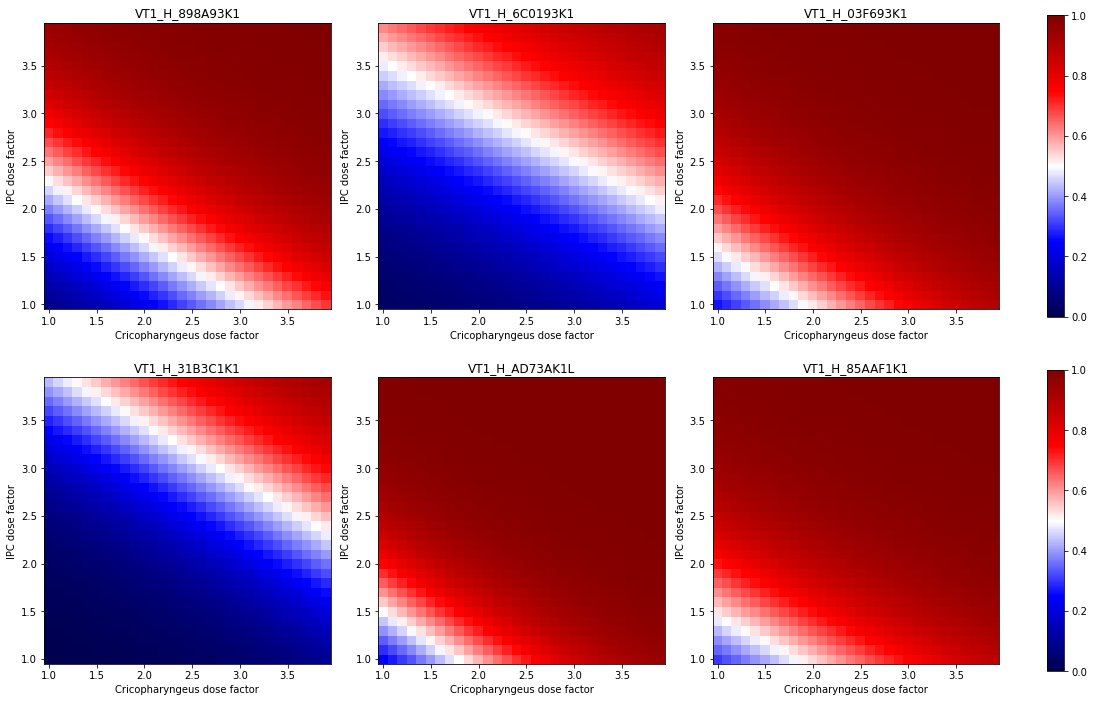

In [21]:
# Try increasing IPC and cricopharyngeal doses
model = lrv.models['original']
factors = np.arange(1, 4, 0.1)
probs = {p: np.zeros((len(factors), len(factors))) for p in df['patient']}
for i, f_i in enumerate(factors):
    for j, f_j in enumerate(factors):
        df_new = df[coefs].copy()
        df_new['ipc_planned'] *= f_i
        df_new['cricopharyngeus_planned'] *= f_j
        current_probs = model.predict_proba(df_new)[:, 1]
        for k, p in enumerate(probs):
            probs[p][i][j] = current_probs[k]

# Plot results
xplot, yplot = np.meshgrid(factors, factors)
fig, ax = plt.subplots(2, 4, figsize=(15.3, 10), gridspec_kw={"width_ratios": [1, 1, 1, 0.06]})
axlist = list(ax[0, :3]) + list(ax[1, :3])
for i, (p, prob) in enumerate(probs.items()):
    mesh = axlist[i].pcolormesh(xplot, yplot, prob, shading='auto',
                         vmin=0, vmax=1, cmap='seismic')
    axlist[i].set_aspect('equal')
    axlist[i].set_title(p)
    axlist[i].set_xlabel("Cricopharyngeus dose factor")
    axlist[i].set_ylabel("IPC dose factor")
    
fig.colorbar(mesh, ax[0, 3])
fig.colorbar(mesh, ax[1, 3])
plt.tight_layout()
plt.savefig('../HeadAndNeck/plots/dose_increase_check.pdf')
                         

### Christianen 2012 dysphagia
https://www.thegreenjournal.com/article/S0167-8140(11)00459-2/fulltext

In [11]:
# Test Christianen dysphagia 2012
# Load 6-month data
df = prepare_data(
    months=6, 
    drop_null=['spc_planned', 'sg_larynx_planned', 'baseline_CTCAE_dysphagia'],
    to_remove={'baseline_CTCAE_dysphagia': [3, 4]}
)

# # Get features and outcomes
# X = df[['spc_planned', 'sg_larynx_planned']]
# y = df['CTCAE_dysphagia']

# # Make model
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression()
# model.fit(X, y)
# model.coef_
# model.coef_ = np.array([[0.057, 0.037]])
# model.intercept_ = np.array([-6.09])

# # Validate
# validate_model(model, X, y, name="Christianen 2012");

[INFO] Dropping 3 entries with null sg_larynx_planned
[INFO] Dropping 6 entries with null baseline_CTCAE_dysphagia
[INFO] Loaded dataset with 173 entries


In [14]:
df['CTCAE_oropharyngeal_pain'].value_counts()

0    173
Name: CTCAE_oropharyngeal_pain, dtype: int64

### Synthetic data investigation

In [254]:
# Generate a dataset
def generate_data_2d(cont_data, cat_data, n_points=None):    
    
    # Check inputs
    if len(cont_data) != len(cat_data):
        print(f'[ERROR]: length of continuous data ({len(cont_data)})'
              f' must be same as length of categorical data ({len(cat_data)})')
    if not n_points:
        n_points = len(cont_data)
    
    # Split continuous data according to categorical data
    cats = cat_data.unique()
    cont_cats = {}
    for c in cats:
        cont_cats[c] = cont_data[cat_data == c]
        
    # Loop through n_points and generate data
    syn_cats = []
    syn_conts = []
    for n in range(n_points):
        
        # Generate category
        def get_random_cat():
            rand1 = np.random.rand()
            return cat_data.quantile(rand1)
        syn_cat = get_random_cat()
        while syn_cat not in cats:
            syn_cat = get_random_cat()
        syn_cats.append(syn_cat)
        
        # Generate continous variable according to distribution within the category
        rand2 = np.random.rand()
        syn_cont = cont_cats[syn_cat].quantile(rand2)
        syn_conts.append(syn_cont)
        
    # Create pandas dataframe
    return pd.DataFrame([syn_conts, syn_cats], index=[cont_data.name, cat_data.name]).T

syn_data_big = generate_data_2d(df['parotid_contralateral_planned'], df['baseline_EORTC_dry_mouth_binary'], 10000)
syn_data = generate_data_2d(df['parotid_contralateral_planned'], df['baseline_EORTC_dry_mouth_binary'])
syn_data.head()
    

,parotid_contralateral_planned,baseline_EORTC_dry_mouth_binary
0,42.684885,0.0
1,37.935499,0.0
2,33.208585,0.0
3,30.443220,0.0
4,12.831539,0.0


Synthetic data:


0.0    0.6906
1.0    0.3094
Name: baseline_EORTC_dry_mouth_binary, dtype: float64

Real data:


0    0.687898
1    0.312102
Name: baseline_EORTC_dry_mouth_binary, dtype: float64

Mean dose (synthetic data): 25.522438503896804
Mean dose (real data): 25.317767490113987


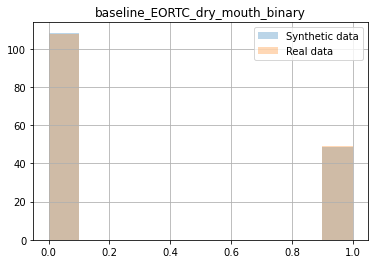

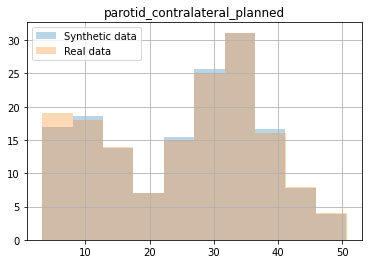

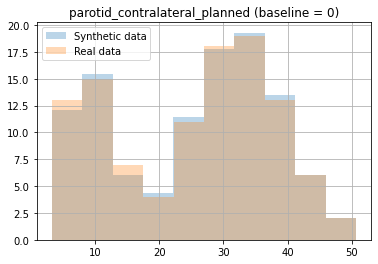

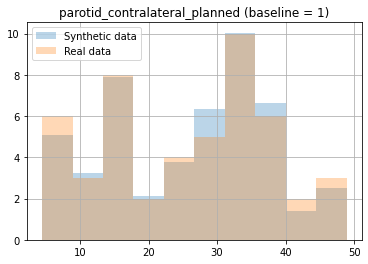

In [255]:
# Check it worked!
# Baseline distribution
print('Synthetic data:')
display(syn_data_big['baseline_EORTC_dry_mouth_binary'].value_counts() / len(syn_data_big))
print('Real data:')
display(df['baseline_EORTC_dry_mouth_binary'].value_counts() / len(df))

# Dose distribution
print('Mean dose (synthetic data):', syn_data_big['parotid_contralateral_planned'].mean())
print('Mean dose (real data):', df['parotid_contralateral_planned'].mean())

# Plot histograms for real/synthetic datasets
def comparison_hists(real_df, syn_df, col, title=''):
    norm = len(real_df) / len(syn_df)
    plt.figure()
    syn_df[col].hist(alpha=0.3, label='Synthetic data', 
                     weights=np.full([len(syn_df)], norm))
    real_df[col].hist(alpha=0.3, label='Real data')
    plt.legend()
    if not title:
        title = col
    plt.title(title)
    
comparison_hists(df, syn_data_big, 'baseline_EORTC_dry_mouth_binary')
comparison_hists(df, syn_data_big, 'parotid_contralateral_planned')
comparison_hists(df[df['baseline_EORTC_dry_mouth_binary'] == 0], 
                 syn_data_big[syn_data_big['baseline_EORTC_dry_mouth_binary'] == 0], 
                 'parotid_contralateral_planned',
                 title='parotid_contralateral_planned (baseline = 0)')
comparison_hists(df[df['baseline_EORTC_dry_mouth_binary'] == 1], 
                 syn_data_big[syn_data_big['baseline_EORTC_dry_mouth_binary'] == 1], 
                 'parotid_contralateral_planned',
                 title='parotid_contralateral_planned (baseline = 1)')



In [260]:
# Smear the data
def smear_data(data, std, var):
    data_smeared = data.copy()
    smear = np.array([np.random.normal(scale=std) for n in range(len(data))])
    data_smeared[var] = data_smeared[var] + smear
    return data_smeared

# Smear binary data
def smear_data_binary(data, std, var=None):
    smear = np.array([np.random.normal(scale=std) for n in range(len(data))])
    def binarise_vals(v):
        return 0 if v < 0.5 else 1
    if isinstance(data, pd.Series):
        smeared_vals = data + smear
        return smeared_vals.apply(binarise_vals)
    else:
        data_smeared = data.copy()
        smeared_vals = data[var] + smear
        data_smeared[var] = smeared_vals.apply(binarise_vals)
        return data_smeared

# Get mean Brier score for a given standard deviation
def get_mean_brier(data, std, model, var=None, n_reps=50):
    
    # Get "true" outcomes
    y_true_init = pd.Series(model.predict(data))
    
    # Check whether variable is binary
    smear_outcome = var == None
    is_binary = False
    if not smear_outcome:
        is_binary = len(data[var].unique()) == 2
    
    # Get Brier scores n times
    scores = []
    for n in range(n_reps):
        
        # Smear input data if needed
        smeared_data = data
        if not smear_outcome:
            smearing_func = smear_data_binary if is_binary else smear_data
            smeared_data = smearing_func(data, std, var)
            
        # Predict outcomes
        y_prob = model.predict_proba(smeared_data)[:, 1]
        
        # Smear "true" outcomes if needed
        y_true = y_true_init if not smear_outcome else smear_data_binary(y_true_init, std)
        
        # Predict Brier score
        scores.append(brier_score_loss(y_true, y_prob))
        
    return np.mean(scores), np.std(scores)

# Plot Brier scores for a range of uncertainties 
def plot_brier_vs_std(data, stds, model, var=None, fit=False, ref=None):
    
    # Get mean Brier score at each standard deviation
    scores = []
    score_stds = []
    for std in stds:
        score, score_std = get_mean_brier(data, std, model, var=var)
        scores.append(score)
        score_stds.append(score_std)
    
    # Plot results
    plt.figure()
    plt.plot(stds, scores, color='k')
    plt.errorbar(stds, scores, yerr=score_stds, color='k', label='Data')
    plt.xlabel(f'Standard deviation of {var}')
    if var == None:
        plt.xlabel(f'Standard deviation of outcome')
    plt.ylabel('Brier score')
    make_leg = False
    
    # Try fitting with parabola
    p = None
    if fit:
        p = np.polyfit(stds, scores, 2)
        x = np.arange(stds.min(), stds.max(), (stds.max() - stds.min()) / 1000)
        y = p[2] + p[1] * x + p[0] * x**2
        print('Parabola fit coefficients:', p)
        plt.plot(x, y, color='r', label='Fit with parabola')
        make_leg = True
        
    # Draw on reference Brier score
    if ref is not None:
        plt.plot([stds.min(), stds.max()], [ref, ref], 'g--', 
                 label=f'Brier score = {ref}', )
        make_leg = True
        
        # Get value of std at reference score
        if fit:
            a = p[0]
            b = p[1]
            c = p[2] - ref
            roots = [(-b + s * np.sqrt(b**2 - 4 * a * c)) / (2 * a) for s in [-1, 1]]
            root = np.max(roots)
            print(f'std. dev. at Brier score = {ref}: {root:.1f}')
    
    if make_leg:
        plt.legend()

    plt.savefig(f'figs/{var}.pdf')

Parabola fit coefficients: [8.16741590e-05 7.15157241e-04 1.56506233e-01]
std. dev. at Brier score = 0.223: 24.5
Parabola fit coefficients: [-0.00742304  0.02659084  0.15487616]
std. dev. at Brier score = 0.223: nan


<ipython-input-260-83685a5ac7aa>:97: RuntimeWarning: invalid value encountered in sqrt
  roots = [(-b + s * np.sqrt(b**2 - 4 * a * c)) / (2 * a) for s in [-1, 1]]


Parabola fit coefficients: [-0.03228243  0.11429304  0.14501306]
std. dev. at Brier score = 0.223: 2.6


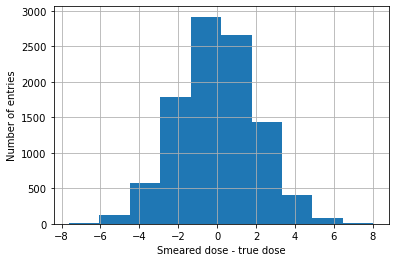

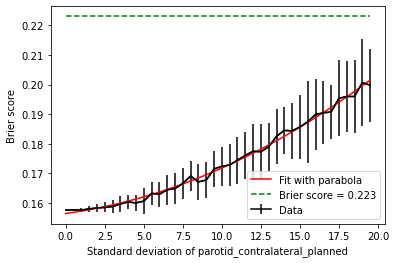

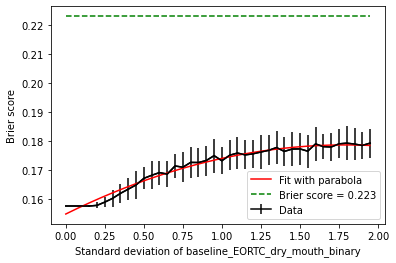

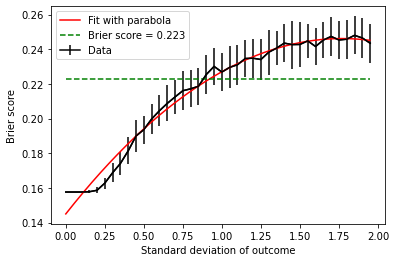

In [261]:
# Check the smearing worked
std = 2
pcp = 'parotid_contralateral_planned'
syn_data_smeared = smear_data(syn_data_big, std, pcp)
(syn_data_smeared[pcp] - syn_data_big[pcp]).hist()
plt.xlabel('Smeared dose - true dose')
plt.ylabel('Number of entries')

# Test range of uncertainties
stds = np.arange(0, 20, 0.5)
ref_score = 0.223
model = lrv.models['original']
plot_brier_vs_std(syn_data, stds, model, var=pcp, fit=True, ref=ref_score)

# Smear baseline score
stds = np.arange(0, 2, 0.05)
plot_brier_vs_std(syn_data, stds, model, var='baseline_EORTC_dry_mouth_binary', fit=True, ref=ref_score)

# Smear outcome
plot_brier_vs_std(syn_data, stds, model, fit=True, ref=ref_score)


Parabola fit coefficients: [9.52045196e-05 5.38676861e-04 1.49683440e-01]
std. dev. at Brier score = 0.223: 25.1
Parabola fit coefficients: [-0.00706427  0.02571953  0.14780728]
std. dev. at Brier score = 0.223: nan


<ipython-input-601-51736303635b>:95: RuntimeWarning: invalid value encountered in sqrt
  roots = [(-b + s * np.sqrt(b**2 - 4 * a * c)) / (2 * a) for s in [-1, 1]]


Parabola fit coefficients: [-0.03284048  0.1193598   0.13776861]
std. dev. at Brier score = 0.223: 2.7


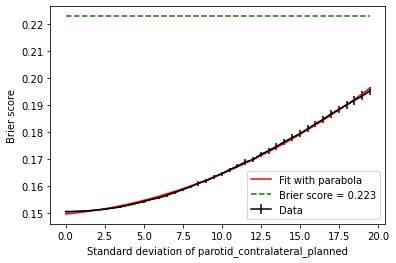

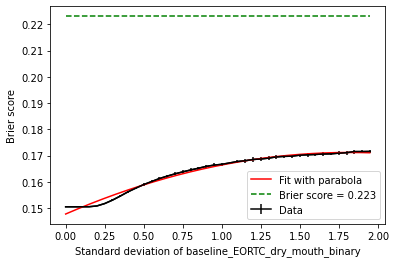

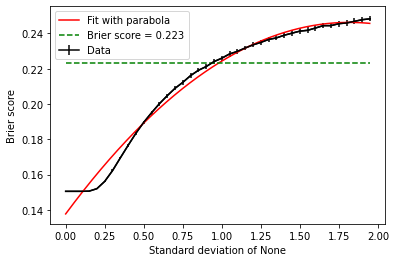

In [603]:
# Repeat for dataset with 10,000 patients
# Test range of uncertainties
stds = np.arange(0, 20, 0.5)
ref_score = 0.223
plot_brier_vs_std(syn_data_big, stds, model, var=pcp, fit=True, ref=ref_score)

# Smear baseline score
stds = np.arange(0, 2, 0.05)
plot_brier_vs_std(syn_data_big, stds, model, var='baseline_EORTC_dry_mouth_binary', fit=True, ref=ref_score)

# Smear outcome
plot_brier_vs_std(syn_data_big, stds, model, fit=True, ref=ref_score)

## Lyman classifer

In [177]:
# Make Lyman classifier
from sklearn.base import ClassifierMixin
from scipy.optimize import curve_fit
from scipy.special import erf

class LymanClassifier(ClassifierMixin):
    
    def fit(self, X, y):
        """Fit the model according to the given training data """
        
        popt, pcov = curve_fit(self._lyman_func, X, y)
        self.D50_ = popt[0]
        self.m_ = popt[1]
            
    def _lyman_func(self, D, D50, m):
        return 0.5 * (1 + erf((D - D50) / (np.sqrt(2) * m * D50)))
    
    def predict_proba(self, X):
        probs = self._lyman_func(np.array(X), self.D50_, self.m_)
        return np.column_stack([1 - probs, probs])
    
    def predict(self, X):
        return np.round(self.predict_proba(X))
    
    def get_params(self):
        return {'D50': self.D50_, 'm': self.m_}
    
    def set_params(self, **params):
        self.D50_ = params['D50']
        self.m_ = params['m']
    
    classes_ = [0, 1]

{'D50': 47.04098498403741, 'm': 0.00021633464149289905}


/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 0.5, 'NTCP')

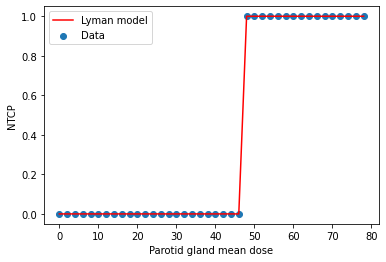

In [183]:
# Test
X = np.arange(0, 80, 2)
D50 = 43.6
m = 0.18
lc = LymanClassifier()

def get_random_y(x, D50, m, std=0.1):
    y_init = lc._lyman_func(x, D50, m)
    y = y_init + np.random.normal(0, std)
    while y < -0.5 or y >= 1.5:
        y = y_init + np.random.normal(0, std)
    return y

y = [get_random_y(x, D50, m) for x in X]
y_scores = [np.round(y) for y in y]

plt.scatter(X, y_scores, label='Data')

lc.fit(X, y_scores)
print(lc.get_params())

y_prob = lc.predict_proba(X)[:, 1]
plt.plot(X, y_prob, 'r', label='Lyman model')
plt.legend()
plt.xlabel('Parotid gland mean dose')
plt.ylabel('NTCP')

## Lee 2012 xerostomia


12 months: removing 17 patients with high-grade xerostomia at baseline
Final cohort: 156 patients
Prevalence: 46.2%
Brier score: 0.2930334642550659
Mean of y_prob: 0.22517087530573668
max brier: 0.17446895221978506
Scaled Brier score: 1.6795737036691816
ROC AUC: 0.6388888888888888
95% confidence interval: [0.55, 0.73]
Calibration slope: -0.0770631719689584
Calibration intercept: 0.5099805613490097
HL chi^2: nan
p-value: nan


<ipython-input-618-f4ded93e3ed0>:119: RuntimeWarning: invalid value encountered in double_scalars
  hl_stat += (zeros[i] - exp_zeros)**2 / exp_zeros + (ones[i] - exp_ones)**2 / exp_ones


<Figure size 432x288 with 0 Axes>

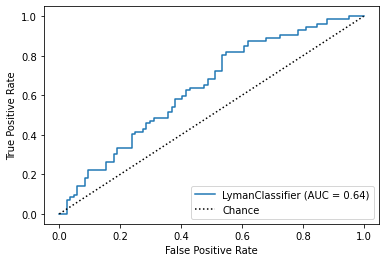

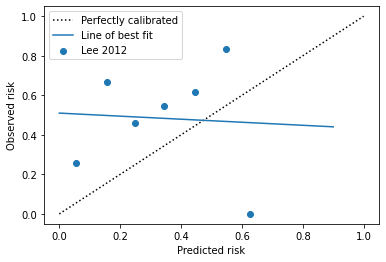

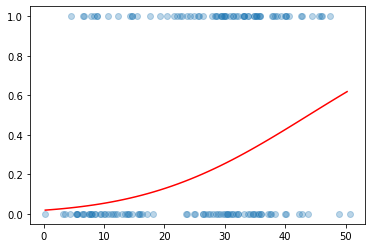

In [623]:
# Test Lee 2012 with LKB
# Load 12-month data
df = pd.read_csv('data/final/late_12_months.csv')

# Remove grade 3+ xerostomia at baseline
df = df[df['baseline_EORTC_dry_mouth'].notnull()]
high_baseline = df[df['baseline_EORTC_dry_mouth'] >= 3]['patient']
print('\n{} months: removing {} patients with high-grade xerostomia at baseline'.format(n, len(high_baseline)))
df = df[~df['patient'].isin(high_baseline_patients)]
print('Final cohort: {} patients'.format(len(df)))

# Create model
lc = LymanClassifier()
lc.set_params(D50=43.9, m=0.48)
#lc.fit(X, y)

# Validate model
X = df['parotid_contralateral_planned']
y = df['EORTC_dry_mouth']
y_prob = validate_model(lc, X, y, name='Lee 2012')

# Plot model vs data
X_plot = np.arange(X.min(), X.max(), 1)
y_plot = lc.predict_proba(X_plot)[:,1]
plt.figure(figsize=(6, 4))
plt.plot(X_plot, y_plot, 'r')
plt.scatter(X, y, alpha=0.3)

## Christianen 2012 dysphagia


12 months: removing 48 patients with high-grade dysphagia at baseline
Final cohort: 154 patients
Prevalence: 32.5%
Brier score: 0.21122852126519734
Mean of y_prob: 0.29887423792409756
max brier: 0.20954842782938746
Scaled Brier score: 1.008017685712144
ROC AUC: 0.6246153846153846
95% confidence interval: [0.53, 0.72]
Calibration slope: 0.6378554278539177
Calibration intercept: 0.11531726948841894
HL chi^2: nan
p-value: nan


<ipython-input-618-f4ded93e3ed0>:119: RuntimeWarning: invalid value encountered in double_scalars
  hl_stat += (zeros[i] - exp_zeros)**2 / exp_zeros + (ones[i] - exp_ones)**2 / exp_ones


<Figure size 432x288 with 0 Axes>

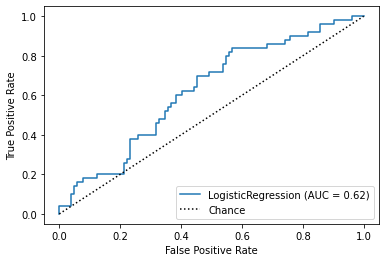

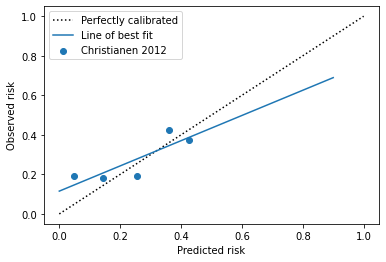

In [636]:
# Test Christianen dysphagia 2012
# Load 6-month data
df = pd.read_csv('data/final/late_6_months.csv')

# Remove grade 2+ dysphagia at baseline
df = df[df['baseline_CTCAE_dysphagia'].notnull() & df['sg_larynx_planned'].notnull()]
high_baseline = df[df['baseline_CTCAE_dysphagia'] >= 1]['patient']
print('\n{} months: removing {} patients with high-grade dysphagia at baseline'.format(n, len(high_baseline)))
df = df[~df['patient'].isin(high_baseline_patients)]
print('Final cohort: {} patients'.format(len(df)))

# Binarise scores
df['baseline_CTCAE_dysphagia'] = df['baseline_CTCAE_dysphagia'] == 1
df['CTCAE_dysphagia'] = df['CTCAE_dysphagia_grade'] >= 1

# Get features and outcomes
X = df[['spc_planned', 'sg_larynx_planned']]
y = df['CTCAE_dysphagia']

# Make model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X, y)
model.coef_
model.coef_ = np.array([[0.057, 0.037]])
model.intercept_ = np.array([-6.09])

# Validate
validate_model(model, X, y, name="Christianen 2012");

<AxesSubplot:>

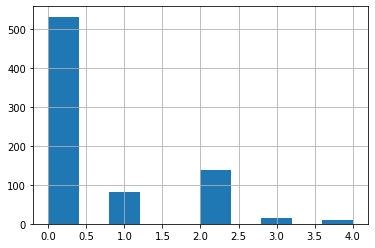

In [675]:
df['CTCAE_dysphagia_grade'].hist()

## Tsai 2017 dysphagia

In [459]:
# Test Tsai dysphagia 2017
# Load all late data
df = pd.read_csv('data/final/late_all.csv')
df = df[df['months'] > 6]
patients = df['patient'].unique()

# Load patient info
patient_info = pd.read_csv('data/final/patient_info.csv')
df2 = patient_info[patient_info['patient'].isin(patients)][['patient', 'age', 'spc_planned', 'primary site', 'SACT_binary']]
df2 = df2[df2['SACT_binary'] == 1]

# Get max dysphagia grade after 6 months
df2['CTCAE_dysphagia_max'] = df2['patient'].apply(lambda p: df[df['patient'] == p]['CTCAE_dysphagia_grade'].max())

# Binarise scores
df2['CTCAE_dysphagia_2'] = df2['CTCAE_dysphagia_max'] >= 2
df2['CTCAE_dysphagia_3'] = df2['CTCAE_dysphagia_max'] >= 3
df2['site'] = df2['primary site'] == 'oropharynx'

# Get features and outcomes
X = df2[['spc_planned', 'age', 'site']]

for g in ['2', '3']:
    
    y = df2['CTCAE_dysphagia_{}'.format(g)]
    print('\n Validating model for grade {}+'.format(g))

    # Make model
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    model.fit(X, y)
    if g == '2':
        model.coef_ = np.array([[0.158, 0.0516, 0.827]])
        model.intercept_ = np.array([-17.2])
    else:
        model.coef_ = np.array([[0.174, 0.0681, 1.49]])
        model.intercept_ = np.array([-21.9])

    # Validate
    y_prob = validate_model("Tsai_{}".format(g), model, X, y);
    


 Validating model for grade 2+


/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-459-922686992e13>:40: RankWarning: Polyfit may be poorly conditioned
  y_prob = validate_model("Tsai_{}".format(g), model, X, y);
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[INFO] Model validation log saved to validation_results/Tsai_2/validation.log

 Validating model for grade 3+

[INFO] Model validation log saved to validation_results/Tsai_3/validation.log


<ipython-input-459-922686992e13>:40: RankWarning: Polyfit may be poorly conditioned
  y_prob = validate_model("Tsai_{}".format(g), model, X, y);


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## Generate simulated data

In [ ]:
    
#     # Perform Hosmer-Lesemow goodness-of-fit test
#     g = 7
#     bin_width = (np.max(y_pred) - np.min(y_pred)) / g
#     bins_low = np.arange(np.min(y_pred), np.max(y_pred), bin_width)
#     ones = np.zeros(g)
#     zeros = np.zeros(g)
#     hl_stat = 0
#     for i in range(g):
        
#         # Get number of true ones and zeros in this group
#         for j, p in enumerate(y_prob):
#             if p > bins_low[i] and p < bins_low[i] + bin_width:
#                 true_y = y.iloc[j]
#                 if true_y:
#                     ones[i] += 1
#                 else:
#                     zeros[i] += 1
                    
#         # Add to the score
#         exp_ones = p * (ones[i] + zeros[i])
#         exp_zeros = ones[i] + zeros[i] - exp_ones
#         hl_stat += (zeros[i] - exp_zeros)**2 / exp_zeros + (ones[i] - exp_ones)**2 / exp_ones
        
#     # Calculate p-value from HL score
#     dof = g - 2
#     pval = chi2.cdf(hl_stat, dof)
#     print('HL chi^2:', hl_stat)
#     print('p-value:', pval)

In [6]:
import json
from scipy.stats import chi2_contingency

def demographics_table(name, df, to_compare=None):
    
    # Load json if required
    name2 = name.replace(' ', '_').lower()
    if to_compare is None:
        with open(f'demographics/{name2}.json') as file:
            to_compare = json.load(file)
    
    # Open latex file and set up table
    file = open(f'demographics/{name2}.tex', 'w')
    file.write('\\begin{table}\n')
    file.write(f'    \\caption{{Demographics and tumour characteristics for the {name} cohort'
                ' (training set) and the VoxTox cohort (validation set).}\n')
    file.write('    \\begin{tabular}{lllll}\n')
    file.write('        \\toprule\n')
    file.write(f'        \\multicolumn{{2}}{{l}}{{Characteristic}} & {name} & VoxTox & $p$-value \\\\\n')
    file.write('        \\midrule\n')
    
    # Write number of patients first if included
    if 'n_patients' in to_compare:
        file.write(f'        \\multicolumn{{2}}{{l}}{{Number of patients}} & {to_compare["n_patients"]}'
                   f' & {len(df)} & \\\\\n')
    
    # Loop through characteristics
    for c in to_compare.keys():
        if c == 'n_patients':
            continue
        file.write(f'        {c.capitalize()} &')
        cats = to_compare[c]
        
        # Make arrays for chisq test
        vals1 = []
        vals2 = []
        
        # Loop through categories of the characteristic
        extra_lines = []
        for i, cat in enumerate(cats.keys()):
            val1 = cats[cat]
            name = cat.capitalize()
            
            # Extract characteristic from VoxTox dataset
            val2 = 0
            counted = 0
            n_other = 0
            
            # Sex
            if c == 'sex':
                val2 = (df['male'] == (cat == 'male')).sum()
                
            # Age
            elif c == 'age':
                if cat.startswith('<'):
                    cutoff = int(cat[2:])
                    val2 = (df['age'] < cutoff).sum()
                    name = f'$< {cutoff}$'
                elif cat.startswith('>'):
                    cutoff = int(cat[2:])
                    val2 = (df['age'] >= cutoff).sum()
                    name = f'$>= {cutoff}$'
                elif cat == 'mean':
                    val2 = f'{df["age"].mean():.1f}'
                elif cat == 'range':
                    val2 = f'{int(df["age"].min())} -- {int(df["age"].max())}'
            
            # Cisplatin/cetuximab
            elif c == 'chemotherapy':
                var_to_use = 'cisplatin' if 'cetuximab' in to_compare else 'SACT'
                val2 = (df[var_to_use] == (cat == 'yes')).sum()
            elif c == 'cetuximab':
                val2 = ((df['SACT'] & ~df['cisplatin']) == (cat == 'yes')).sum()
                
            # Tumour site
            elif c == 'site':
                site = cat
                if cat == 'unknown primary':
                    site = 'CUP'
                if cat == 'other':
                    n_other = val1
                    continue
                val2 = (df['primary site'] == site).sum()
                counted += val2
                
            # Tumour classification
            elif c == 'tumour classification':
                T_stage = int(cat[-1])
                val2 = (df['T_stage'] == T_stage).sum()
            elif c == 'node classification':
                val2 = ((df['N_stage'] > 0) == (cat == 'positive')).sum()
                
            # Neck irradiation
            elif c == 'bilateral neck irradiation':
                val2 = (df['neck_bi'] == (cat == 'yes')).sum()
                
            # Unknown characteristic
            else:
                print(f'[INFO] Characteristic {c} not recognised!')
                
                
            # Add values to arrays
            vals1.append(val1)
            vals2.append(val2)
                
            # Write info to file
            if i == 0:
                file.write(f' {name} & {val1} & {val2} & ')
            else:
                extra_lines.append(f'        & {name} & {val1} & {val2} & \\\\\n')
                
        # Extra line for patients with other tumour sites
        if c == 'site' and (counted != len(df) or n_other):
            diff = len(df) - counted
            extra_lines.append(f'        & Other & {n_other} & {diff} & \\\\\n')
            vals1.append(n_other)
            vals2.append(diff)
            site_list = list(cats.keys()) + ['CUP']
            sites_missed = df[~df['primary site'].isin(site_list)]['primary site'].unique()
            print('[INFO] The following tumour sites were classified as "other":')
            print('      ', sites_missed)
                
        # Calculate p-value
        obs = np.array([vals1, vals2])
        chi2, p_val, dof, exp = chi2_contingency(obs)
        p_to_write = '$< 0.01$' if p_val < 0.01 else f'{p_val:.2f}'
        file.write(f'{p_to_write} \\\\\n')
        
        # Write extra lines
        for line in extra_lines:
            file.write(line)
            
    # End table
    file.write('        \\bottomrule\n')
    file.write('    \\end{tabular}\n')
    file.write('\\end{table}\n')
    file.write(f'\\label{{tab:{name2}_demog}}\n')
    file.close()
    